# Two-dimensional Burgers equation

Multi-dimensional Burgers equations form into simultaneous PDEs. The governing equations targeted here are
as follows.
$$
\left\{\begin{array}{l}
u_{t}+u u_{x}+v u_{y}=0 \\
v_{t}+u v_{x}+v v_{y}=0 
\end{array}\right.$$


The boundary and initial conditions for Burgers equations can be set arbitrarily. The boundary conditions are set to be periodic as shown below,
$$\left\{\begin{array}{l}
\boldsymbol{u}(x, y, t)=\frac{x+y-2\cdot x \cdot t}{1-2\cdot t^2}, x \in \{0,1\} \\
\boldsymbol{v}(x, y, t)=\frac{x-y-2\cdot y \cdot t}{1-2\cdot t^2}, y \in \{0,1\}
\end{array}\right.$$

where  $\boldsymbol{u}(x, y, t)=\left(u(x, y, t), v(x, y, t)\right) $. The initial conditions are set using trigonometric functions as shown below,
$$\left\{\begin{array}{l}
u_{0}= x+y \\
v_{0}= x-y
\end{array}\right.$$

## 1.Setup

In [1]:
import torch
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from math import *
import time
import copy


# %%
torch.set_default_tensor_type('torch.DoubleTensor')

## 2.Hyperparameter

In [2]:
dimension = 3
input_width,layer_width = dimension, 4
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

## 3.Neural Architecture

In [3]:
# %%
# activation function
def activation(x):
    return x * torch.sigmoid(x)

class Net(torch.nn.Module):
    def __init__(self,input_width,layer_width,layer_depth):
        super(Net,self).__init__()
        self.layer_in = torch.nn.Linear(input_width, layer_width)
        for i in range(layer_depth-1):
            setattr(self, 'layer'+str(i), torch.nn.Linear(layer_width, layer_width))
        self.layer_out = torch.nn.Linear(layer_width, 2)
    def forward(self,x,layer_depth):
        y = activation(self.layer_in(x))
        for i in range(layer_depth-1):
            y = activation(getattr(self, 'layer'+str(i))(y))
        output = self.layer_out(y)
        return output

${\rm N}(\vec{x}) := {\rm A}_{\rm 4}(\sigma{\rm A}_3({\sigma}{\rm A}_2({\sigma}{\rm A}_{\rm 1}(\vec{x}))))\ ,$, where

${\rm A}_{\rm in}: \mathbb{R}^3{→}\mathbb{R}^w$, ${\rm A}_1: \mathbb{R}^w{→}\mathbb{R}^w$, ${\rm A}_2: \mathbb{R}^w{→}\mathbb{R}^w$, ${\rm A}_{\rm out}: \mathbb{R}^w{→}\mathbb{R}^2$, 

note: there are $2w^2+8w+2$ parameters need to be trained in total in ${\rm N}(x)$

## 4.Training setup

### 4.1 Initialize the weights using Xavier normal initialization

In [4]:
# %%
# Xavier normal initialization for weights:
#             mean = 0 std = gain * sqrt(2 / fan_in + fan_out)
# zero initialization for biases
def initialize_weights(self):
    for m in self.modules():
        if isinstance(m,nn.Linear):
            nn.init.xavier_normal_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()



### 4.2 Define $u_0$, $v_0$

$$\left\{\begin{array}{l}
u_{0}(x, y, 0)= x + y \\
v_{0}(x, y, 0)= x - y
\end{array}\right.$$

In [5]:
# Define u_0
def u_0(X):
    u_temp = torch.zeros(X.shape[0],1)
    x = X[:,0]
    y = X[:,1]
    u_temp[:,0] = x + y

    return u_temp.reshape([X.size()[0],1]).to(device)

def v_0(X):
    u_temp = torch.zeros(X.shape[0],1)
    x = X[:,0]
    y = X[:,1]
    u_temp[:,0] = x - y

    return u_temp.reshape([X.size()[0],1]).to(device)


### 4.3 Define the exact solution


$$\left.\begin{array}{l}
u(x, y, t)=\frac{x+y-2\cdot x \cdot t}{1-2\cdot t^2}, \\
v(x, y, t)=\frac{x-y-2\cdot y \cdot t}{1-2\cdot t^2},
\end{array}\right\}(\mathrm{x}, \mathrm{y}) \in \Omega,
$$

Computational domain is taken as a square domain $ \Omega=\{(x, y): 0 \leq x \leq 1,0 \leq y \leq 1\} $. In this problem, the initial and boundary conditions for $ u(x, y, t) $ and $ v(x, y, t) $ have been taken from the above analytical solutions.Computational domain is taken as a square domain $ \Omega=\{(x, y): 0 \leq x \leq 1,0 \leq y \leq 1\} $. In this problem, the initial and boundary conditions for  $u(x, y, t)$ and $ v(x, y, t) $ have been taken from the above analytical solutions.

In [6]:
def u_exact(X):
    x = X[:,0]
    y = X[:,1]
    t = X[:,2]
    # u(x, y, t)=\frac{x+y-2\cdot x \cdot t}{1-2\cdot t^2}, 
    temp1 = (x+y-2*x*t)/(1-2*t**2)
    # v(x, y, t)=\frac{x-y-2\cdot y \cdot t}{1-2\cdot t^2},
    temp2 = (x-y-2*y*t)/(1-2*t**2)
    u_temp = torch.zeros(x.size()[0],2)
    u_temp[:,0] = temp1
    u_temp[:,1] = temp2
    return u_temp.reshape([x.size()[0],2]).to(device)

In [7]:
def g_0x(X):
    x = torch.zeros([X.shape[0],1])[:,0].to(device)
    x.requires_grad = True
    y = X[:,1].to(device)
    t = X[:,2].to(device)
    # use cuda torch to write temp1 = (x+y-2*x*t)/(1-2*t**2)
    temp1 = torch.divide(torch.add(torch.add(x,y),torch.neg(torch.mul(torch.mul(2,x),t))),torch.add(torch.neg(torch.mul(torch.mul(2,t),t)),1))
    u_temp = temp1
    return u_temp.reshape([x.size()[0], 1])
    
def g_1x(X):
    x = torch.ones([X.shape[0],1])[:,0].to(device)
    x.requires_grad = True
    y = X[:,1].to(device)
    t = X[:,2].to(device)
    # use cuda torch to write temp1 = (x+y-2*x*t)/(1-2*t**2)
    temp1 = torch.divide(torch.add(torch.add(x,y),torch.neg(torch.mul(torch.mul(2,x),t))),torch.add(torch.neg(torch.mul(torch.mul(2,t),t)),1))
    u_temp = temp1
    return u_temp.reshape([x.size()[0], 1])


def g_0y(X):
    x = X[:,0].to(device)
    y = torch.zeros([X.shape[0],1])[:,0].to(device)
    y.requires_grad = True
    t = X[:,2].to(device)
    # use cuda torch to write temp1 = (x-y-2*y*t)/(1-2*t**2)
    temp1 = torch.divide(torch.add(torch.sub(x,y),torch.neg(torch.mul(torch.mul(2,y),t))),torch.add(torch.neg(torch.mul(torch.mul(2,t),t)),1))
    u_temp = temp1
    return u_temp.reshape([x.size()[0], 1])

def g_1y(X):
    x = X[:,0].to(device)
    y = torch.ones([X.shape[0],1])[:,0].to(device)
    y.requires_grad = True
    t = X[:,2].to(device)
    # use cuda torch to write temp1 = (x-y-2*y*t)/(1-2*t**2)
    temp1 = torch.divide(torch.add(torch.sub(x,y),torch.neg(torch.mul(torch.mul(2,y),t))),torch.add(torch.neg(torch.mul(torch.mul(2,t),t)),1))
    u_temp = temp1
    return u_temp.reshape([x.size()[0], 1])


### 4.4 Build the model

$x = {\vec X}[:,0]$

$y = {\vec X}[:,1]$

$t = {\vec X}[:,2]$

Model for training on initial and boundary:
$${\rm model_x}({x,y,t}) := {\rm u}(x,y, t)   $$
$${\rm model_y}({x,y,t}) := {\rm v}(x,y, t)  $$
Model for training on boundary:
$${\rm model_x}({x,y,t}) := {\rm u}(x,y, t) \cdot x \cdot (1-x)  +  (1-x) ⋅ g_{x}(0,y,t) + x \cdot g_{x}(1,y,t)$$
$${\rm model_y}({x,y,t}) := {\rm v}(x,y, t) \cdot y \cdot (1-y)  +  (1-y) ⋅ g_{y}(x,0,t) + y \cdot g_{y}(x,0,t) $$
Model for training on initial:
$${\rm model_x}({x,y,t}) := {\rm u}(x,y, t) ⋅ t  +  (1-t) ⋅ u_{0}(x,y,0)$$
$${\rm model_y}({x,y,t}) := {\rm v}(x,y, t) ⋅ t  +  (1-t) ⋅ v_{0}(x,y,0)$$

In [8]:
def model(X,initial = False, boundary = False):
    net_ux = net(X,layer_depth)[:, 0].reshape([X.size()[0],1])
    net_uy = net(X,layer_depth)[:, 1].reshape([X.size()[0],1])
    x = X[:,0].reshape([X.size()[0],1])
    y = X[:,1].reshape([X.size()[0],1])
    t = X[:,2].reshape([X.size()[0],1])
    t_minus = (0.5 - t).reshape([t.size()[0],1])
    x_minus = (1.0 - x).reshape([x.size()[0],1])
    y_minus = (1.0 - y).reshape([y.size()[0],1])
    model_u_temp = torch.zeros(X.shape[0],2)
    if initial == False and boundary == False:
        model_u_temp[:,0] = (net_ux).reshape([X.shape[0]])
        model_u_temp[:,1] = (net_uy).reshape([X.shape[0]])
    elif initial == False and boundary == True:
        model_u_temp[:,0] = (net_ux*x*x_minus + (1-x)*g_0x(X) + x*g_1x(X)).reshape([X.shape[0]])
        model_u_temp[:,1] = (net_uy*y*y_minus + (1-y)*g_0y(X) + y*g_1y(X)).reshape([X.shape[0]])
    else:
        model_u_temp[:,0] = (net_ux*t + u_0(X)*t_minus*2).reshape([X.shape[0]])
        model_u_temp[:,1] = (net_uy*t + v_0(X)*t_minus*2).reshape([X.shape[0]])
    return model_u_temp.reshape([x.size()[0], 2]).to(device)

### 4.6 Define Loss function

Considering the governing equations are simultaneous PDEs, the loss function is set as follows.

$$L=\left(L_{1}^{2}+L_{2}^{2}\right)+\left(L_{3}^{2}+L_{4}^{2}\right)+\left(L_{5}^{2}+L_{6}^{2}\right)
$$

 $L_{1}$  and $ L_{2} $ that are parts of the loss function correspond to the evaluations of differential operators.

$$\left\{\begin{aligned}
L_{1} &=\frac{\partial f_{x}^{1}}{\partial t}+f_{x}^{1} \frac{\partial f_{x}^{1}}{\partial x}+f_{y}^{1} \frac{\partial f_{x}^{1}}{\partial y}\\
L_{2} &=\frac{\partial f_{y}^{1}}{\partial t}+f_{x}^{1} \frac{\partial f_{y}^{1}}{\partial x}+f_{y}^{1} \frac{\partial f_{y}^{1}}{\partial y}
\end{aligned}\right.$$

Here, $ f_{x}^{1} $ and  $f_{y}^{1}$  mean $ f_{x}\left(x_{1}, y_{1}, t_{1}\right)$  and  $f_{y}\left(x_{1}, y_{1}, t_{1}\right)$ , respectively. $ L_{3}$  and $ L_{4} $ correspond to the evaluation of boundary conditions.


$$\left\{\begin{array}{r}
L_{3}=f_{x}\left(x_{2}, y_{2}, t_{2}\right)-\left\{\begin{array}{ll}
f_{x}\left(0, y_{2}, t_{2}\right) & \left(x_{2}=1\right) \\
f_{x}\left(1, y_{2}, t_{2}\right) & \left(x_{2}=0\right)
\end{array}\right. \\
L_{4}=f_{y}\left(x_{2}, y_{2}, t_{2}\right)-\left\{\begin{array}{ll}
f_{y}\left(x_{2}, 0, t_{2}\right) & \left(y_{2}=1\right) \\
f_{y}\left(x_{2}, 1, t_{2}\right) & \left(y_{2}=0\right)
\end{array}\right.
\end{array}\right.$$

$ L_{5} $ and $ L_{6} $ correspond to the evaluation of initial conditions,

$$\left\{\begin{array}{l}
L_{5}=f_{x}\left(x_{3}, y_{3}, 0\right)-(x_{3} + y_{3}) \\
L_{6}=f_{y}\left(x_{3}, y_{3}, 0\right)-(x_{3} - y_{3})
\end{array}\right.$$

where $ f_{x} $ and $ f_{y} $ are approximate solutions predicted as an output of DNN. $ x_{1}$, $y_{1} $, and $ t_{1} $ are the space-time coordinate points extracted randomly from the computational domain; $ x_{2}$,$ y_{2} $, and $ t_{2} $ are the space-time coordinate points extracted randomly from the regions corresponding to the boundary conditions; and $ x_{3} $ and $ y_{3} $ are the space coordinate points extracted randomly from the regions corresponding to the initial conditions. The training of DNN is conducted from the case of $ v$=0.01 , which has the highest value for $ v$ , in descending order of value. As discussed later, it is easier to train for high $ \nu $, and the convergence of the training can be accelerated even for low $ v $ using the training results of the weight parameters for high $ v $ as the initial values. The initial values for weight parameters in the case of $ v=0.01$  are random numbers based on the Xavier initialization. Otherwise, the weight parameters from the previous training result are used as the initial values.


In [9]:
def loss_function(x1, x2, x3, initial=False, boundary=False):
    # first term
    # u_hat1 is require grad
    u_hat1 = model(x1, initial, boundary)
    u_hat1_x = u_hat1[:, 0].reshape([x1.size()[0],1])
    u_hat1_y = u_hat1[:, 1].reshape([x1.size()[0],1])
    grad_u_hat1_x = torch.autograd.grad(outputs = u_hat1_x, inputs = x1, grad_outputs = torch.ones(u_hat1_x.shape).to(device), create_graph = True)  # dx dy and dt
    grad_u_hat1_y = torch.autograd.grad(outputs = u_hat1_y, inputs = x1, grad_outputs = torch.ones(u_hat1_y.shape).to(device), create_graph = True)  # dx dy and dt
    dx1 = grad_u_hat1_x[0][:, 0].reshape([x1.size()[0],1])  # dx
    dy1 = grad_u_hat1_x[0][:, 1].reshape([x1.size()[0],1])  # dy
    dt1 = grad_u_hat1_x[0][:, 2].reshape([x1.size()[0],1])  # dt
    dx2 = grad_u_hat1_y[0][:, 0].reshape([x1.size()[0],1])  # dx
    dy2 = grad_u_hat1_y[0][:, 1].reshape([x1.size()[0],1])  # dy
    dt2 = grad_u_hat1_y[0][:, 2].reshape([x1.size()[0],1])  # dt
    L1 = torch.add(dt1,torch.mul(dx1,u_hat1_x))
    L1 = torch.add(L1,torch.mul(dy1,u_hat1_y))
    L1 = L1.pow(2).sum()
    L1 = torch.div(L1, len(x1))
    L2 = torch.add(dt2,torch.mul(dx2,u_hat1_x))
    L2 = torch.add(L2,torch.mul(dy2,u_hat1_y))
    L2 = L2.pow(2).sum()
    L2 = torch.div(L2, len(x1))

    # second term
    if boundary == False:
        x2_x0 = x2[0: len(x2)//4]
        u_hat2_x_0 = model(x2_x0, initial, boundary)
        u_hat2_x_0_p = g_0x(x2_x0)
        L3 = torch.add(u_hat2_x_0_p,torch.neg(u_hat2_x_0))
        L3 = L3.pow(2).sum()

        x2_x1 = x2[len(x2)//4: len(x2)//2]
        u_hat2_x_1 = model(x2_x1, initial, boundary)
        u_hat2_x_1_p = g_1x(x2_x1)
        # L3 += (u_hat2_x_1_p - u_hat2_x_1).pow(2).sum()
        L3 = torch.add(L3,torch.add(u_hat2_x_1_p,torch.neg(u_hat2_x_1)).pow(2).sum())
        L3 = torch.div(L3, len(x2))

        x2_y0 = x2[len(x2)//2: 3*len(x2)//4]
        u_hat2_y_0 = model(x2_y0, initial, boundary)
        u_hat2_y_0_p = g_0y(x2_y0)
        L4 = torch.add(u_hat2_y_0_p,torch.neg(u_hat2_y_0)).pow(2).sum()

        x2_y1 = x2[3*len(x2)//4: len(x2)]
        u_hat2_y_1 = model(x2_y1, initial, boundary)
        u_hat2_y_1_p = g_1y(x2_y1)
        # L4 += (u_hat2_y_1_p - u_hat2_y_1).pow(2).sum()
        L4 = torch.add(L4,torch.add(u_hat2_y_1_p,torch.neg(u_hat2_y_1)).pow(2).sum())
        L4 = torch.div(L4, len(x2))
    else:
        L3 = torch.tensor(0.0).to(device)
        L4 = torch.tensor(0.0).to(device)

    # third term
    if initial == False:
        u_hat3 = model(x3, initial, boundary)
        u_hat3_x = u_hat3[:, 0].reshape([x3.size()[0],1])
        u_hat3_y = u_hat3[:, 1].reshape([x3.size()[0],1])
        u_0_x = u_0(x3).reshape([x3.size()[0],1])
        u_0_y = v_0(x3).reshape([x3.size()[0],1])
        L5 = torch.add(u_hat3_x,torch.neg(u_0_x)).pow(2).sum()
        L6 = torch.add(u_hat3_y,torch.neg(u_0_y)).pow(2).sum()
        L5 = torch.div(L5, len(x3))
        L6 = torch.div(L6, len(x3))
    else:
        L5 = torch.tensor(0.0).to(device)
        L6 = torch.tensor(0.0).to(device)

#     print(L1.item(), L2.item(), L3.item(), L4.item(), L5.item(), L6.item())
    return L1 + L2 + L3 + L4 + L5 + L6


  

In [10]:
def generate_sample_one(data_size):
    sample_temp = torch.rand(data_size,3)
    # the third element of sample_temp is 0-0.5
    sample_temp[:, 2] = sample_temp[:, 2] * 0.5
    sample_temp.requires_grad = True
    return sample_temp.to(device)

def generate_sample_two(data_size):
    sample_temp = torch.rand(data_size,3)
    sample_temp[:, 2] = sample_temp[:, 2] * 0.5
    # make the first element of sample_temp to be 0 in the first quarter
    sample_temp[0: len(sample_temp)//4, 0] = 0
    # make the first element of sample_temp to be 1 in the second quarter
    sample_temp[len(sample_temp)//4: len(sample_temp)//2,0] = 1
    # make the second element of sample_temp to be 0 in the third quarter
    sample_temp[len(sample_temp)//2: 3*len(sample_temp)//4, 1] = 0
    # make the second element of sample_temp to be 1 in the fourth quarter
    sample_temp[3*len(sample_temp)//4: len(sample_temp), 1] = 1
    sample_temp.requires_grad = True
    return sample_temp.to(device)

def generate_sample_three(data_size):
    sample_temp = torch.rand(data_size,3)
    sample_temp[:, 2] = 0
    sample_temp.requires_grad = True
    return sample_temp.to(device)


In [11]:
dimension = 3
input_width,layer_width = dimension, 4
layer_depth = 2


# Testing data for 3-dimensional
test_data_3 = torch.zeros((21, 21, 21, 3))
for i in range(21):
  x_test = i / 20
  for j in range(21):
    y_test = j / 20
    for k in range(21):
      t_test = k / 40
      test_data_3[i][j][k][0] = x_test
      test_data_3[i][j][k][1] = y_test
      test_data_3[i][j][k][2] = t_test
test_data_3 = torch.reshape(test_data_3, (21*21*21, 3)).to(device)


In [12]:
def cal_error(x,initial, boundary):
    u_hat_x = model(x,initial, boundary)[:, 0]
    u_hat_y = model(x,initial, boundary)[:, 1]
    u_x = u_exact(x)[:, 0]
    u_y = u_exact(x)[: ,1]
    error = (((u_hat_x - u_x).norm(2))**2 + ((u_hat_y - u_y).norm(2))**2) / ((u_y.norm(2))**2 + (u_x.norm(2))**2)
    # print(x)
    # print(u_x)
    # print(u_hat_x)
    return error

In [13]:
def plot_loss_epoch(loss_record_all, error_record_all,epoch, var_loss, var_error,layer_width):
    para = 2 * layer_width * layer_width + 8 * layer_width + 2
    fig = plt.figure()
    # Set subplots size
    fig.set_figheight(15)
    fig.set_figwidth(20)

    ax = fig.add_subplot(2, 1, 1)
    # plot a smooth curve of loss
    ax.plot(np.arange(epoch), loss_record_all[0])
    ax.plot(np.arange(epoch), loss_record_all[1])
    ax.plot(np.arange(epoch), loss_record_all[2])
    # append error bar to the plot 
    ax.errorbar(np.arange(epoch), loss_record_all[0], yerr=var_loss[0], label='vanilla')
    ax.errorbar(np.arange(epoch), loss_record_all[1], yerr=var_loss[1], label='boundary-included')
    ax.errorbar(np.arange(epoch), loss_record_all[2], yerr=var_loss[2], label='initial-included')

    ax.set_xlabel('epoch')
    ax.set_ylabel('Empirical loss')
    ax.set_title("Empirical loss for 2D Burgers' equation, epoch = 30000, Parameters: {}, lr = 0.001, mesh_size = 2400".format(para))
    ax.set_yscale("log")
    ax.legend()

    ax = fig.add_subplot(2, 1, 2)
    # plot a smooth curve of loss
    ax.plot(np.arange(epoch), error_record_all[0])
    ax.plot(np.arange(epoch), error_record_all[1])
    ax.plot(np.arange(epoch), error_record_all[2])
    # append error bar to the plot
    ax.errorbar(np.arange(epoch), error_record_all[0], yerr=var_error[0], label='vanilla')
    ax.errorbar(np.arange(epoch), error_record_all[1], yerr=var_error[1], label='boundary-included')
    ax.errorbar(np.arange(epoch), error_record_all[2], yerr=var_error[2], label='initial-included')

    ax.set_xlabel('epoch')
    ax.set_ylabel('Fractional error w.r.t true solution')
    ax.set_title("Fractional error w.r.t true solution, epoch = 30000, Parameters: {}, lr = 0.001,mesh_size = 2400".format(para))
    ax.set_yscale("log")
    ax.legend()

    # plt.savefig('loss_epoch,2D, epoch = 30000, Parameters: {}, lr = 0.001,mesh_size = 2400.png'.format(para))



## 5.Doing the training

current layer width: 4
current run: 0
current epoch is:  00
current loss is:  tensor(4.5794)
total time is:  5.6856067180633545 seconds
current epoch is:  00
current loss is:  tensor(0.0823)
total time is:  6.642924070358276 seconds
current epoch is:  00
current loss is:  tensor(7.1548)
total time is:  6.461779832839966 seconds
current run: 1
current epoch is:  00
current loss is:  tensor(3.9641)
total time is:  6.1628029346466064 seconds
current epoch is:  00
current loss is:  tensor(0.0012)
total time is:  9.608990907669067 seconds
current epoch is:  00
current loss is:  tensor(6.6026)
total time is:  6.128891944885254 seconds
current run: 2
current epoch is:  00
current loss is:  tensor(5.0080)
total time is:  6.610711097717285 seconds
current epoch is:  00
current loss is:  tensor(0.0179)
total time is:  7.466508150100708 seconds
current epoch is:  00
current loss is:  tensor(7.0414)
total time is:  6.126615047454834 seconds
current run: 3
current epoch is:  00
current loss is:  te

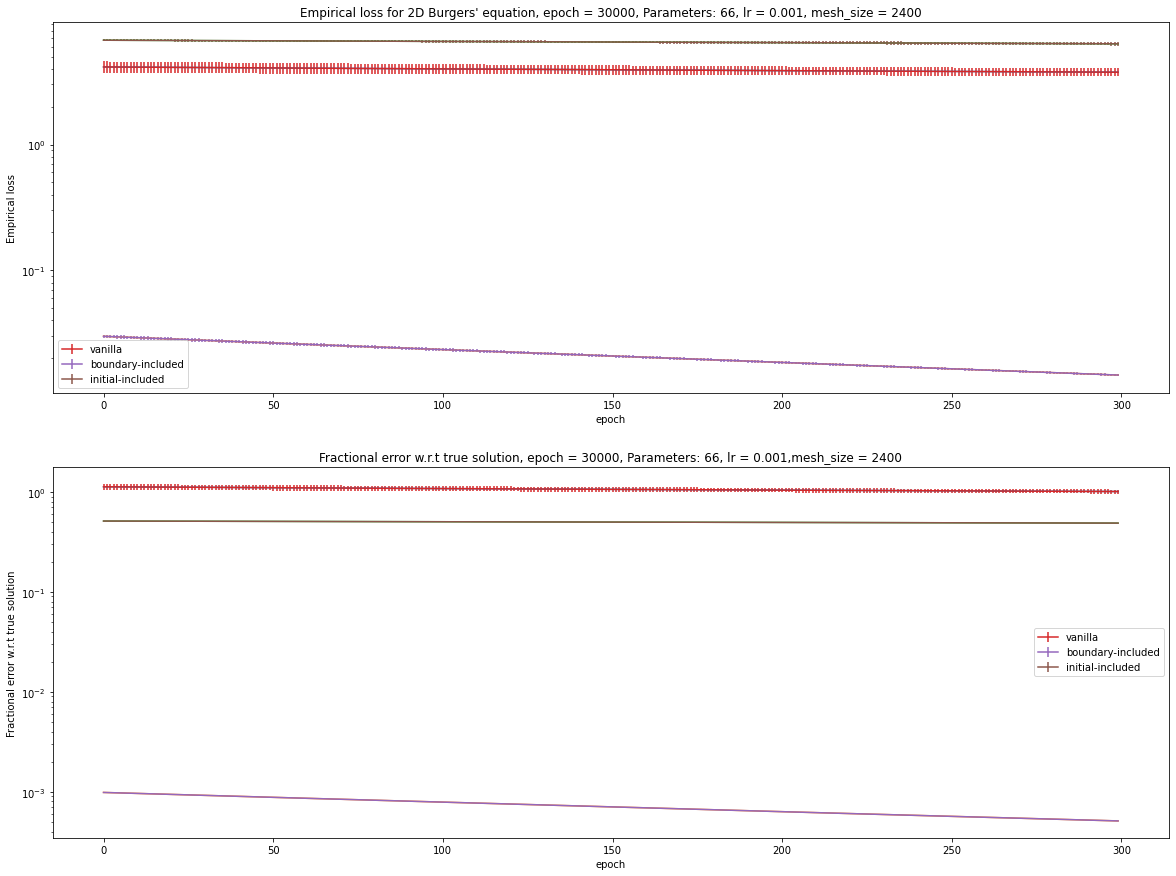

In [14]:
epoch = 300
import pickle
layer_width_list = [4]

for i in range(len(layer_width_list)):
  layer_width = layer_width_list[i]
  print("current layer width: {}".format(layer_width))
  loss_record_all = [[],[],[]]
  error_record_all = [[],[],[]]
  for i in range(5):
    print("current run: {}".format(i))
    net = Net(input_width,layer_width, layer_depth)
    initialize_weights(net)
    optimizer = optim.Adam(net.parameters(),lr=0.0001)
    # %%
    loss_record = np.zeros(epoch)
    error_record = np.zeros(epoch)
    data_size = 2400
    x1 = generate_sample_one(data_size//3)
    x2 = generate_sample_two(data_size//3)
    x3 = generate_sample_three(data_size//3)
    time_start = time.time()
    for i in range(epoch):
        # scale_y[i] = float(model(scale_x))
        optimizer.zero_grad()
        loss = loss_function(x1, x2, x3, initial = False, boundary=False)
        loss_record[i] = float(loss)
        loss.backward()
        optimizer.step() 
        error_record[i] = cal_error(test_data_3, initial=False, boundary=False)
        torch.cuda.empty_cache() # clear memory
        print("Now epoch number is:{}".format(i),end='\r')
        if i % 2500 == 0:
          # y2.append(model(x2))
          print("current epoch is: ", i)
          print("current loss is: ", loss.detach())
    time_end = time.time()
    print('total time is: ', time_end-time_start, 'seconds')
    # plot_heatmap("venilla",initial=False, boundary=False)
    loss_record_all[0].append(loss_record)
    error_record_all[0].append(error_record)

    net = Net(input_width,layer_width, layer_depth)
    initialize_weights(net)
    optimizer = optim.Adam(net.parameters(),lr=0.0001)
    # %%
    loss_record = np.zeros(epoch)
    error_record = np.zeros(epoch)
    time_start = time.time()
    for i in range(epoch):
        # scale_y[i] = float(model(scale_x))
        optimizer.zero_grad()
        loss = loss_function(x1, x2, x3, initial = False, boundary=True)
        loss_record[i] = float(loss)
        loss.backward()
        optimizer.step() 
        error_record[i] = cal_error(test_data_3, initial=False, boundary=True)
        torch.cuda.empty_cache() # clear memory
        print("Now epoch number is:{}".format(i),end='\r')
        if i % 2500 == 0:
          # y2.append(model(x2))
          print("current epoch is: ", i)
          print("current loss is: ", loss.detach())

    time_end = time.time()
    print('total time is: ', time_end-time_start, 'seconds')
    loss_record_all[1].append(loss_record)
    error_record_all[1].append(error_record)
    # plot_heatmap("boundary-included",initial=False, boundary=True)


    net = Net(input_width,layer_width, layer_depth)
    initialize_weights(net)
    optimizer = optim.Adam(net.parameters(),lr=0.0001)
    # %%
    loss_record = np.zeros(epoch)
    error_record = np.zeros(epoch)
    time_start = time.time()
    for i in range(epoch):
        # scale_y[i] = float(model(scale_x))
        optimizer.zero_grad()
        loss = loss_function(x1, x2, x3, initial = True, boundary=False)
        loss_record[i] = float(loss)
        loss.backward()
        optimizer.step() 
        error_record[i] = cal_error(test_data_3, initial=True, boundary=False)
        torch.cuda.empty_cache() # clear memory
        print("Now epoch number is:{}".format(i),end='\r')
        if i % 2500 == 0:
          # y2.append(model(x2))
          print("current epoch is: ", i)
          print("current loss is: ", loss.detach())
    time_end = time.time()
    print('total time is: ', time_end-time_start, 'seconds')
    # plot_heatmap("initial-included",initial=True, boundary=False)
    loss_record_all[2].append(loss_record)
    error_record_all[2].append(error_record)

  # with open('2D_burger_loss_record_all_{}.pkl'.format(layer_width), 'wb') as f:
  #     pickle.dump([loss_record_all,error_record_all], f)

  avg_loss_record = []
  avg_error_record = []

  var_error_record = []
  var_loss_record = []
  for i in range(len(loss_record_all)):
      avg_loss_record.append(np.mean(loss_record_all[i], axis=0))
      avg_error_record.append(np.mean(error_record_all[i], axis=0))
      var_error_record.append(np.var(error_record_all[i], axis=0))
      var_loss_record.append(np.var(loss_record_all[i], axis=0))

  plot_loss_epoch(avg_loss_record, avg_error_record, epoch,var_loss_record, var_error_record, layer_width)





In [15]:
print(avg_loss_record)

[array([4.13615379, 4.13457193, 4.13299227, 4.13141482, 4.12983962,
       4.12826669, 4.12669605, 4.12512775, 4.1235618 , 4.12199823,
       4.12043708, 4.11887838, 4.11732214, 4.11576839, 4.11421716,
       4.11266846, 4.11112233, 4.10957877, 4.10803782, 4.10649947,
       4.10496376, 4.10343069, 4.10190028, 4.10037254, 4.09884747,
       4.0973251 , 4.09580542, 4.09428845, 4.09277418, 4.09126263,
       4.08975379, 4.08824767, 4.08674427, 4.08524359, 4.08374562,
       4.08225037, 4.08075783, 4.07926801, 4.07778088, 4.07629645,
       4.07481472, 4.07333567, 4.0718593 , 4.0703856 , 4.06891456,
       4.06744617, 4.06598042, 4.06451731, 4.06305681, 4.06159893,
       4.06014364, 4.05869094, 4.05724082, 4.05579326, 4.05434824,
       4.05290577, 4.05146582, 4.05002839, 4.04859346, 4.04716101,
       4.04573104, 4.04430353, 4.04287847, 4.04145585, 4.04003565,
       4.03861786, 4.03720247, 4.03578947, 4.03437885, 4.03297059,
       4.03156468, 4.03016111, 4.02875987, 4.02736095, 4.0259

In [16]:

avg_loss_record = []
avg_error_record = []

var_error_record = []
var_loss_record = []
for i in range(len(loss_record_all)):
    avg_loss_record.append(np.mean(loss_record_all[i], axis=0))
    avg_error_record.append(np.mean(error_record_all[i], axis=0))
    var_error_record.append(np.var(error_record_all[i], axis=0))
    var_loss_record.append(np.var(loss_record_all[i], axis=0))